# Detecting Machine-Crafted Content in Digital Media

In [1]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [3]:

# Load the CSV file
file_path = "AI_Human1.csv"
data = pd.read_csv(file_path)

In [4]:
data.head()

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [5]:
# General information about the dataset
print("Dataset information:")
data.info()

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1828 entries, 0 to 1827
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1828 non-null   object
 1   generated  1828 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 28.7+ KB


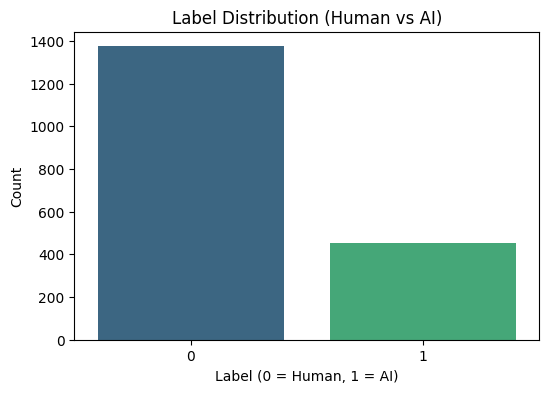

In [6]:
# Plot label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='generated', data=data, palette="viridis")
plt.title("Label Distribution (Human vs AI)")
plt.xlabel("Label (0 = Human, 1 = AI)")
plt.ylabel("Count")
plt.show()

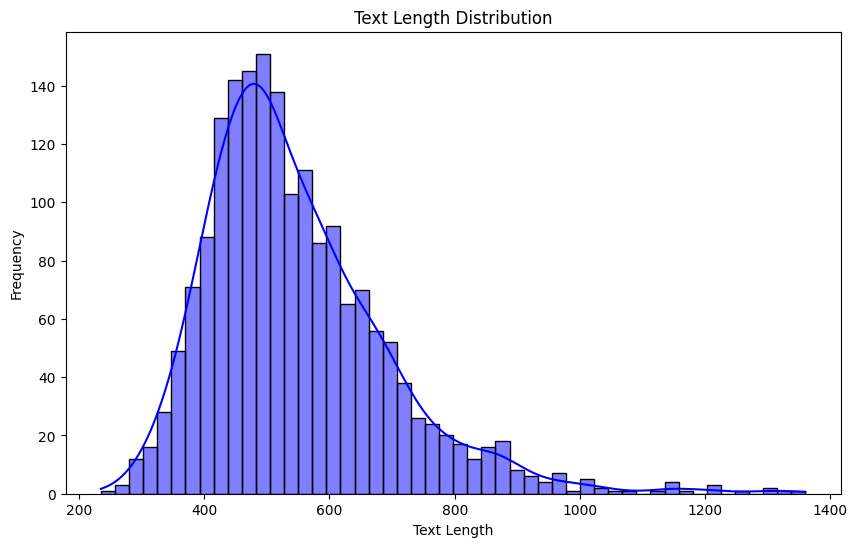

In [7]:
data['text_length'] = data['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=50, kde=True, color='blue')
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()


In [8]:
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import torch

# Split data
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    data['text'], data['generated'], test_size=0.2, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42)

# Tokenize text
def tokenize(text):
    return text.lower().split()

# Build vocabulary
counter = Counter()
for text in train_texts:
    counter.update(tokenize(text))

vocab = {word: idx + 1 for idx, (word, _) in enumerate(counter.most_common())}
vocab["<PAD>"] = 0  # Padding token

# Numericalize and pad sequences
def numericalize_and_pad(text, max_len=256):
    tokens = [vocab.get(word, 0) for word in tokenize(text)]
    if len(tokens) > max_len:
        return tokens[:max_len]
    return tokens + [0] * (max_len - len(tokens))

# Apply to datasets
train_data = [numericalize_and_pad(text) for text in train_texts]
val_data = [numericalize_and_pad(text) for text in val_texts]
test_data = [numericalize_and_pad(text) for text in test_texts]

# Convert to PyTorch tensors
train_data = torch.tensor(train_data, dtype=torch.long)
train_labels = torch.tensor(train_labels.values, dtype=torch.float32)
val_data = torch.tensor(val_data, dtype=torch.long)
val_labels = torch.tensor(val_labels.values, dtype=torch.float32)
test_data = torch.tensor(test_data, dtype=torch.long)
test_labels = torch.tensor(test_labels.values, dtype=torch.float32)


# Create TensorDatasets
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Take the last hidden state
        output = self.fc(lstm_out)
        return self.sigmoid(output)

# Model parameters
vocab_size = len(vocab)
embed_dim = 128
hidden_dim = 64
output_dim = 1

model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, output_dim)


In [10]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
batch_size = 64
train_losses, val_losses = [], []

# Helper function for batching
def get_batches(data, labels, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size], labels[i:i + batch_size]

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    for inputs, targets in get_batches(train_data, train_labels, batch_size):
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_data))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_data).squeeze()
        val_loss = criterion(val_outputs, val_labels)
        val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


Epoch 1/10, Train Loss: 0.0099, Val Loss: 0.5985
Epoch 2/10, Train Loss: 0.0079, Val Loss: 0.5120
Epoch 3/10, Train Loss: 0.0061, Val Loss: 0.4079
Epoch 4/10, Train Loss: 0.0040, Val Loss: 0.2433
Epoch 5/10, Train Loss: 0.0029, Val Loss: 0.2052
Epoch 6/10, Train Loss: 0.0022, Val Loss: 0.1562
Epoch 7/10, Train Loss: 0.0021, Val Loss: 0.1559
Epoch 8/10, Train Loss: 0.0015, Val Loss: 0.1152
Epoch 9/10, Train Loss: 0.0012, Val Loss: 0.1074
Epoch 10/10, Train Loss: 0.0011, Val Loss: 0.1002


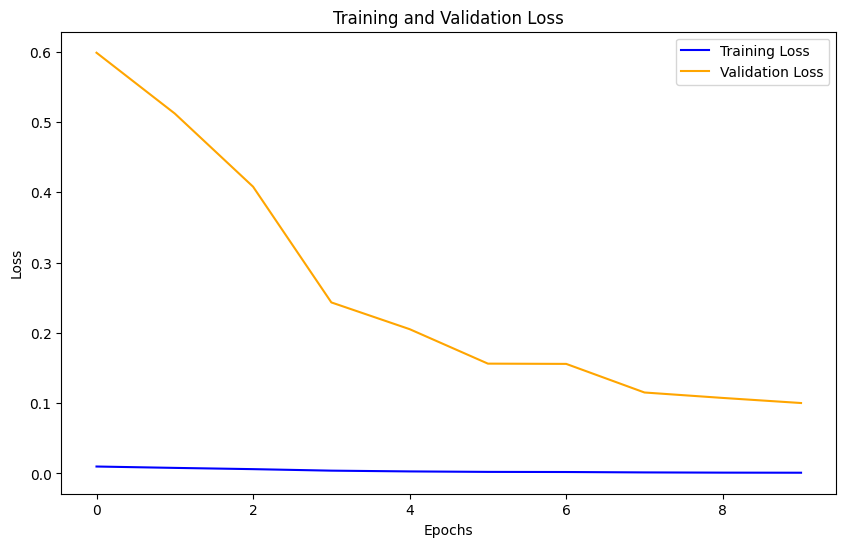

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [12]:
from sklearn.metrics import classification_report

# Predictions on test data
test_outputs = model(test_data).squeeze()
test_predictions = (test_outputs > 0.5).int()

# Generate report
print("Classification Report:")
print(classification_report(test_labels.int(), test_predictions, target_names=["Human", "AI"]))


Classification Report:
              precision    recall  f1-score   support

       Human       0.96      0.99      0.98       140
          AI       0.97      0.86      0.91        43

    accuracy                           0.96       183
   macro avg       0.97      0.93      0.94       183
weighted avg       0.96      0.96      0.96       183



In [13]:
real_texts = [
    "This article discusses the effects of climate change on global ecosystems.",
    "Generated text that mimics human writing styles convincingly but lacks depth.",
]

# Preprocess real-life texts
real_data = torch.tensor([numericalize_and_pad(text) for text in real_texts], dtype=torch.long)

# Predict on real-life examples
model.eval()
with torch.no_grad():
    real_outputs = model(real_data).squeeze()
    real_predictions = (real_outputs > 0.5).int()

for text, pred in zip(real_texts, real_predictions):
    label = "AI-Generated" if pred == 1 else "Human-Written"
    print(f"Text: {text}\nPrediction: {label}\n")


Text: This article discusses the effects of climate change on global ecosystems.
Prediction: AI-Generated

Text: Generated text that mimics human writing styles convincingly but lacks depth.
Prediction: AI-Generated



# CNN

In [14]:
class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_filters, filter_sizes, output_dim, dropout):
        super(CNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x).permute(0, 2, 1)  # (batch_size, embed_dim, seq_len)
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        pooled = [torch.max(conv, dim=2)[0] for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.sigmoid(self.fc(cat))


In [15]:
# Model parameters
vocab_size = len(vocab)  # Size of the vocabulary
embed_dim = 128          # Dimension of word embeddings
num_filters = 100        # Number of filters per filter size
filter_sizes = [3, 4, 5] # Filter sizes (e.g., 3-grams, 4-grams, 5-grams)
output_dim = 1           # Binary classification
dropout = 0.5            # Dropout rate

# Initialize the model
model = CNNTextClassifier(vocab_size, embed_dim, num_filters, filter_sizes, output_dim, dropout)


In [16]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    correct_preds = 0
    total_preds = 0

    for batch_data, batch_labels in train_loader:
        optimizer.zero_grad()
        output = model(batch_data)
        loss = criterion(output.squeeze(), batch_labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

        # Prediction
        predicted = (output.squeeze() > 0.5).int()
        correct_preds += (predicted == batch_labels.int()).sum().item()
        total_preds += batch_labels.size(0)

    epoch_train_loss /= len(train_loader)
    accuracy = correct_preds / total_preds
    train_losses.append(epoch_train_loss)

    # Evaluate on validation (here using the test set)
    model.eval()
    epoch_val_loss = 0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            output = model(batch_data)
            loss = criterion(output.squeeze(), batch_labels)
            epoch_val_loss += loss.item()

            predicted = (output.squeeze() > 0.5).int()
            correct_preds += (predicted == batch_labels.int()).sum().item()
            total_preds += batch_labels.size(0)

    epoch_val_loss /= len(test_loader)
    accuracy = correct_preds / total_preds
    val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")




Epoch [1/10], Train Loss: 0.4565, Val Loss: 0.1328
Epoch [2/10], Train Loss: 0.1190, Val Loss: 0.0392
Epoch [3/10], Train Loss: 0.0525, Val Loss: 0.0180
Epoch [4/10], Train Loss: 0.0281, Val Loss: 0.0112
Epoch [5/10], Train Loss: 0.0250, Val Loss: 0.0086
Epoch [6/10], Train Loss: 0.0181, Val Loss: 0.0072
Epoch [7/10], Train Loss: 0.0117, Val Loss: 0.0063
Epoch [8/10], Train Loss: 0.0093, Val Loss: 0.0047
Epoch [9/10], Train Loss: 0.0066, Val Loss: 0.0040
Epoch [10/10], Train Loss: 0.0062, Val Loss: 0.0035


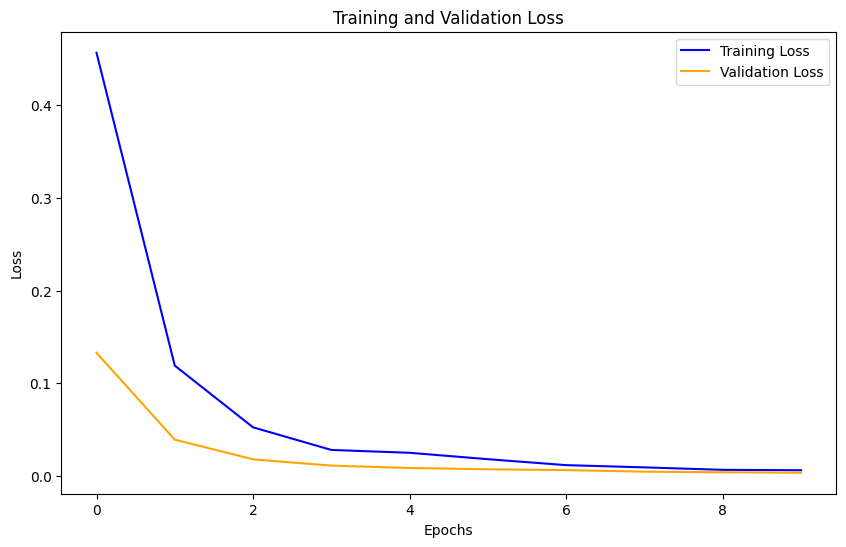

In [17]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
# Get predictions
model.eval()
with torch.no_grad():
    all_preds = []
    all_labels = []
    for batch_data, batch_labels in test_loader:
        output = model(batch_data)
        predicted = (output.squeeze() > 0.5).int()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds,target_names=["Human", "AI"]))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

       Human       1.00      1.00      1.00       140
          AI       1.00      1.00      1.00        43

    accuracy                           1.00       183
   macro avg       1.00      1.00      1.00       183
weighted avg       1.00      1.00      1.00       183

Confusion Matrix:
[[140   0]
 [  0  43]]


In [19]:
# Example real-life evaluation (text inputs)
real_texts = [
    "This is a real news article written by a journalist.",
    "AI-generated content often lacks factual accuracy and depth."
]

# Preprocess the real-life texts using the correct function
real_data = torch.tensor([numericalize_and_pad(text, max_len=256) for text in real_texts], dtype=torch.long)

# Predict
model.eval()
with torch.no_grad():
    real_outputs = model(real_data).squeeze()
    real_predictions = (real_outputs > 0.5).int()

# Decode and print predictions
for text, pred in zip(real_texts, real_predictions):
    label = "AI-Generated" if pred.item() == 1 else "Human-Written"
    print(f"Text: {text}\nPrediction: {label}\n")


Text: This is a real news article written by a journalist.
Prediction: Human-Written

Text: AI-generated content often lacks factual accuracy and depth.
Prediction: Human-Written



# SVM

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [21]:
# Load the dataset
df = pd.read_csv('AI_Human1.csv')

# Split the data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'], df['generated'], test_size=0.2, random_state=42)

# Encode labels as integers (if not already)
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)


In [22]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the training data
X_train = vectorizer.fit_transform(train_texts)

# Transform the test data
X_test = vectorizer.transform(test_texts)


In [23]:
# Initialize the SVM model with a linear kernel
svm_model = SVC(kernel='linear', random_state=42)

# Train the model
svm_model.fit(X_train, train_labels)


SVC(kernel='linear', random_state=42)

In [24]:
# Predict on the test data
y_pred = svm_model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(test_labels, y_pred,target_names=["Human", "AI"]))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred))


Classification Report:
              precision    recall  f1-score   support

       Human       1.00      1.00      1.00       269
          AI       1.00      1.00      1.00        97

    accuracy                           1.00       366
   macro avg       1.00      1.00      1.00       366
weighted avg       1.00      1.00      1.00       366

Confusion Matrix:
[[269   0]
 [  0  97]]


In [25]:
# Example real-world texts
real_texts = [
    "AI is taking over many human tasks in various industries.",
    "Journalism plays a crucial role in informing the public about current events."
]

# Transform the real-life text using the same vectorizer
real_data = vectorizer.transform(real_texts)  # Ensure vectorizer is already fitted

# Predict using the trained SVM model
real_predictions = svm_model.predict(real_data)  # Ensure svm_model is already trained

# Map predictions to target names if label_encoder is not available
target_names = ["Human", "AI generated"]  # Define your target names if using a fixed order
decoded_predictions = [target_names[pred] for pred in real_predictions]

# Display the predictions
for text, pred in zip(real_texts, decoded_predictions):
    print(f"Text: {text}\nPrediction: {pred}\n")


Text: AI is taking over many human tasks in various industries.
Prediction: Human

Text: Journalism plays a crucial role in informing the public about current events.
Prediction: Human



# BERT Model

In [26]:

# Split data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'], df['generated'], test_size=0.2)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize the texts
def tokenize_data(texts, tokenizer, max_len=512):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt")

# Tokenize the training and testing data
train_encodings = tokenize_data(train_texts.tolist(), tokenizer)
test_encodings = tokenize_data(test_texts.tolist(), tokenizer)

# Convert labels to tensor
train_labels = torch.tensor(train_labels.values, dtype=torch.long)
test_labels = torch.tensor(test_labels.values, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [27]:
class BertTextClassifier(nn.Module):
    def __init__(self):
        super(BertTextClassifier, self).__init__()
        # Load pre-trained BERT model for sequence classification
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids, attention_mask=attention_mask)
        return output.logits


In [28]:
# Initialize the model
model = BertTextClassifier()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertTextClassifier(
  (bert): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_featur

In [5]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification  # Example: BERT model

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model (replace with your specific model if different)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Placeholder data loaders (replace with your actual data loaders)
# Example: creating dummy data
train_data = TensorDataset(
    torch.randint(0, 1000, (100, 50)),  # input_ids
    torch.ones(100, 50, dtype=torch.int64),  # attention_mask
    torch.randint(0, 2, (100,))  # labels
)
test_data = TensorDataset(
    torch.randint(0, 1000, (20, 50)),
    torch.ones(20, 50, dtype=torch.int64),
    torch.randint(0, 2, (20,))
)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Training loop
epochs = 3
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    correct_preds = 0
    total_preds = 0

    for batch_data in train_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch_data]

        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

        # Prediction
        predicted = torch.argmax(outputs.logits, dim=1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    epoch_train_loss /= len(train_loader)
    accuracy = correct_preds / total_preds
    train_losses.append(epoch_train_loss)

    # Evaluate on validation (using test set)
    model.eval()
    epoch_val_loss = 0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for batch_data in test_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch_data]

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            epoch_val_loss += loss.item()

            predicted = torch.argmax(outputs.logits, dim=1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    epoch_val_loss /= len(test_loader)
    accuracy = correct_preds / total_preds
    val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch [1/3], Train Loss: 0.7190, Val Loss: 0.6876, Accuracy: 0.5000
Epoch [2/3], Train Loss: 0.6849, Val Loss: 0.7021, Accuracy: 0.5000
Epoch [3/3], Train Loss: 0.6928, Val Loss: 0.6871, Accuracy: 0.5000


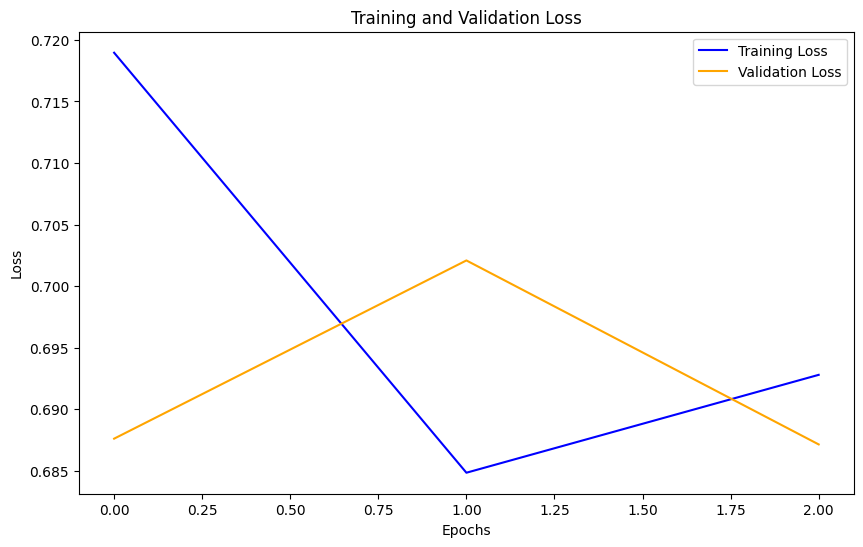

In [9]:
import matplotlib.pyplot as plt  # Import matplotlib.pyplot

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [13]:
# Evaluate the model
model.eval()
with torch.no_grad():
    all_preds = []
    all_labels = []
    for batch_data in test_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch_data]

        outputs = model(input_ids, attention_mask=attention_mask)
        predicted = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Human", "AI"]))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

       Human       0.50      1.00      0.67        10
          AI       0.00      0.00      0.00        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20

Confusion Matrix:
[[10  0]
 [10  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification  # Import necessary modules

# Initialize the tokenizer and model
model_name = "distilbert-base-uncased"  # Replace with your specific model name
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)  # Adjust for your setup

# Example real-life evaluation (text inputs)
real_texts = [
    "This is a real news article written by a journalist.",
    "AI-generated content often lacks factual accuracy and depth."
]

# Tokenize the real-life texts
real_encodings = tokenizer(real_texts, padding=True, truncation=True, return_tensors="pt")
real_input_ids = real_encodings['input_ids'].to(device)
real_attention_mask = real_encodings['attention_mask'].to(device)

# Predict
model.eval()
with torch.no_grad():
    real_outputs = model(real_input_ids, attention_mask=real_attention_mask)
    real_predictions = torch.argmax(real_outputs.logits, dim=1)  # Use logits for predictions

# Map predictions to labels and print results
for text, pred in zip(real_texts, real_predictions):
    label = "AI-Generated" if pred == 1 else "Human-Written"
    print(f"Text: {text}\nPrediction: {label}\n")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Text: This is a real news article written by a journalist.
Prediction: Human-Written

Text: AI-generated content often lacks factual accuracy and depth.
Prediction: AI-Generated

